## Packages and Assets

In [35]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


In [36]:
model = keras.models.load_model('../../assets/lstm_assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           2405100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,695,023
Trainable params: 289,923
Non-

In [37]:
with open('../../assets/lstm_assets/word_index.json', 'r') as f:
    word_index = json.load(f)
    word_index = dict(word_index)

In [38]:
# Load the tokenizer from the file
with open('../../assets/lstm_assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

## Functions

In [39]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df[column_name] = df[column_name].map(lambda s: s.replace('-feira', ''))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'mais '))
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'menos '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' por cento'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'less'))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'plus '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' percent'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df[column_name] = df[column_name].map(lambda s: s.replace('R$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('U$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('US$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df[column_name] = df[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df[column_name] = df[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df[column_name] = df[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df[column_name] = df[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df[column_name] = df[column_name].map(lambda s: s.replace('\"', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('“', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df[column_name] = df[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df[column_name] = df[column_name].map(lambda s: s.strip())
    return df

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Loading test data

In [40]:
test_raw = pd.read_csv('../../assets/data/splits/test/raw.csv')
test_raw

,title,tags,link,label
0,Relator mantém imposto de exportação em novo p...,"['Combustíveis', 'Diesel', 'Dividendos', 'Econ...",https://www.moneytimes.com.br/relator-mantem-i...,0
1,Petrobras informa descoberta de petróleo em po...,"['ANP', 'Brasil', 'Commodities', 'Empresas', '...",https://www.moneytimes.com.br/petrobras-inform...,0
2,"Itaúsa compra 8,5% da empresa de saneamento Ae...","['Aegea', 'Brasil', 'Empresas', 'Itaú Unibanco...",https://www.moneytimes.com.br/itausa-compra-85...,2
3,"Petrobras (PETR4) afunda 20,71% no pior dia de...","['PETR3', 'Petrobras (PETR4)']",https://www.suno.com.br/noticias/petrobras-pet...,0
4,"Petrobras aumenta diesel em 4,2% e gasolina em...","['Diesel', 'Economia', 'Empresas', 'Gasolina',...",https://www.moneytimes.com.br/petrobras-vai-el...,0
...,...,...,...,...
1191,"Futuros do minério de ferro avançam 0,33% na b...","['China', 'Commodities', 'Minério de ferro', '...",https://www.moneytimes.com.br/futuros-do-miner...,1
1192,"Com sucesso de operação do Daycoval, bancos ca...","['ABC Brasil', 'Banco do Brasil', 'Banco Pan',...",https://www.moneytimes.com.br/com-sucesso-de-o...,2
1193,Vale (VALE3): Justiça de Belo Horizonte aceita...,"['recuperação judicial', 'Samarco', 'Vale (VAL...",https://www.suno.com.br/noticias/vale-vale3-ju...,1
1194,Petrobras anuncia reabertura de refinaria de P...,"['Empresas', 'Petrobras', 'Petroquímico']",https://www.moneytimes.com.br/petrobras-anunci...,0


In [41]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[1291,  101, 1359, ...,   55,    0,    0],
       [   3,  503, 2006, ...,    0,    0,    0],
       [ 122,   56,    2, ...,  191,    0,    0],
       ...,
       [   4,   12,   97, ...,  177,    0,    0],
       [   3,   68, 6799, ...,    0,    0,    0],
       [ 494,   46,  456, ...,  153,    7, 1667]])

### Functions

In [42]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [43]:
index_word = index2word(word_index)

In [44]:
pred_prob = model.predict(test_padded)

38/38 [==============================] - 4s 18ms/step


In [45]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [46]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[1291, 101, 1359, 444, 53, 2051, 19, 4461, 55]",relator mantem imposto exportacao novo parecer...,"[combate, fatia, estrategico, futura, combusti...",2,0
1,"[3, 503, 2006, 21, 1043, 702, 176, 111]",petrobras informa descoberta petroleo poco blo...,"[petrobras, futuro, pronta, semana, externa, m...",0,0
2,"[122, 56, 2, 5, 114, 3722, 1, 2, 191]",itausa compra <NUM> cento empresa saneamento a...,"[ter, btg, num, cento, ainda, temem, <OOV>, nu...",2,2
3,"[3, 8, 1221, 2, 5, 1139, 57, 286, 134, 335, 1894]",petrobras petr4 afunda <NUM> cento pior dia de...,"[petrobras, petr4, leste, num, cento, fleury, ...",0,0
4,"[3, 145, 35, 2, 5, 26, 2, 5, 67]",petrobras aumenta diesel <NUM> cento gasolina ...,"[petrobras, anos, diesel, num, cento, gasolina...",0,0
...,...,...,...,...,...
1191,"[83, 11, 13, 375, 2, 5, 36, 168, 44]",futuros minerio ferro avancam <NUM> cento bols...,"[agora, minerio, ferro, suspensao, num, cento,...",1,1
1192,"[162, 3010, 239, 3910, 46, 1, 2, 29, 154, 2]",com sucesso operacao daycoval bancos captam <N...,"[o, vamo3, capital, comercializacao, fecha, <O...",1,2
1193,"[4, 12, 97, 4635, 1, 1243, 265, 538, 177]",vale vale3 justica belo horizonte aceita recup...,"[vale, vale3, conselho, atuam, <OOV>, negociad...",1,1
1194,"[3, 68, 6799, 166, 990, 16, 1, 1]",petrobras anuncia reabertura refinaria pasaden...,"[petrobras, eleva, instituto, bba, nacional, v...",0,0


### Metrics

In [47]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
# cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       614
           1       0.75      0.84      0.79       375
           2       0.51      0.71      0.59       207

    accuracy                           0.78      1196
   macro avg       0.74      0.77      0.75      1196
weighted avg       0.81      0.78      0.79      1196

Confusion Matrix


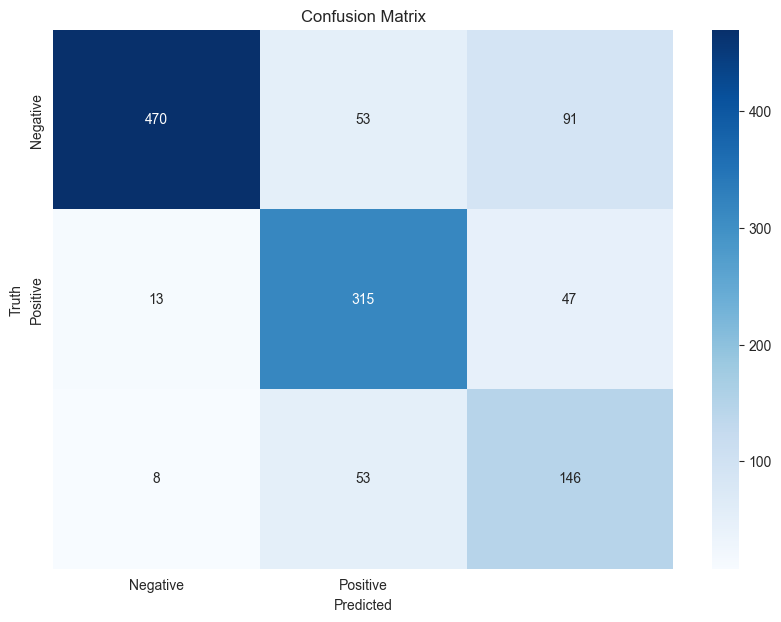

In [48]:
print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
show_confusion_matrix(cm)